# Importing Packages

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    cuda_device = torch.cuda.current_device()
else:
    device = torch.device("cpu")
    cuda_device = -1

In [2]:
from pathlib import Path 
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
from collections import defaultdict

from tqdm.auto import tqdm

import pickle
from collections import defaultdict
import gc

import matplotlib.pyplot as plt
%matplotlib inline

import umap
import umap.plot
from sklearn.decomposition import PCA

In [3]:
import sklearn.cluster as cluster

# Read the dataset

In [4]:
df = pd.read_pickle('datasets/train_turn.pkl')


# Getting the Declutr Embeddings 

In [6]:
import torch
from scipy.spatial.distance import cosine

from transformers import AutoModel, AutoTokenizer

# Load the model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("johngiorgi/declutr-base")
model = AutoModel.from_pretrained("johngiorgi/declutr-base")
model.to(device)

def get_de_embs(text):
    # Prepare some text to embed

    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)

    # Embed the text
    with torch.no_grad():
        sequence_output = model(**inputs)[0]

    # Mean pool the token-level embeddings to get sentence-level embeddings
    embeddings = torch.sum(
        sequence_output * inputs["attention_mask"].unsqueeze(-1), dim=1
    ) / torch.clamp(torch.sum(inputs["attention_mask"], dim=1, keepdims=True), min=1e-9)
    return embeddings


Some weights of the model checkpoint at johngiorgi/declutr-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Embeddings for your text

In [ ]:
emb_dict = defaultdict(list)
text_turns = list(set(df['text']))

saving_foler = 'embeddings_temp/'

for i in tqdm(range(len(text_turns)), total=len(text_turns)):
    cur_text = text_turns[i] 
    emb_dict[cur_text] = list(get_de_embs(cur_text)[0].cpu().numpy())
    
    if (i%50000 == 0 or i == len(text_turns)-1) and i != 0:
        with open(saving_folder+'/embs'+str(int(i/50000)+(0 if i%50000 == 0 else 1))+'.pkl','wb') as f:
            pickle.dump(emb_dict, f)
        torch.cuda.empty_cache()
        del emb_dict
        emb_dict = defaultdict(list)
        gc.collect()

# Dimension Reduction

## read embeddings for all unique turns

In [8]:
turn_emb_dict = defaultdict(list)
for i in tqdm(range(1,17), total=16):
    with open('embeddings_temp/embs'+str(i)+'.pkl','rb') as f:
        cur_dict = pickle.load(f)
        turn_emb_dict.update(cur_dict)
len(turn_emb_dict)

  0%|          | 0/16 [00:00<?, ?it/s]

768790

In [9]:
clusterable_embedding_de_enh = list(turn_emb_dict.values())

## PCA

In [ ]:
pca = PCA().fit(clusterable_embedding_de_enh)

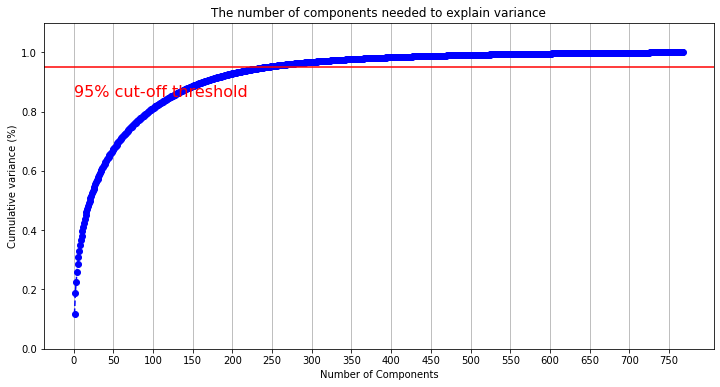

In [24]:
# generate the explaination of variation chart to pick the threshold
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 769, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 768, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [10]:
THRESHOLD = 250# change this number based on the chart above
lowd_embs = PCA(n_components=THRESHOLD).fit_transform(clusterable_embedding_de_enh)

## UMAP

In [19]:
# UMAP Reducing to 50D
reducer = umap.UMAP(n_components=50, 
                    n_neighbors=30, 
                    min_dist=0.0, 
                    random_state=42, 
                    transform_seed=42, 
                    verbose=False)

embedding_umap = reducer.fit_transform(lowd_embs)

In [20]:
embedding_umap

array([[-0.79176086,  0.41379032,  7.661116  , ...,  8.444708  ,
         7.7819157 ,  7.7948895 ],
       [-0.16116552,  0.85453326,  7.1658254 , ...,  8.313762  ,
         7.874744  ,  7.2290792 ],
       [ 0.7723029 ,  0.7535192 ,  6.9945087 , ...,  8.247243  ,
         7.8363404 ,  7.435885  ],
       ...,
       [-0.56224394,  0.6131011 ,  5.9657574 , ...,  8.177265  ,
         7.9146996 ,  7.314894  ],
       [ 0.22384684,  0.7627514 ,  7.3816056 , ...,  8.232982  ,
         7.895295  ,  7.4710937 ],
       [-0.5721646 ,  0.47533372,  5.5487537 , ...,  8.264686  ,
         7.8424654 ,  7.428904  ]], dtype=float32)

## Clustering and Visualization

### Elbow Chart

In [ ]:
import sklearn.cluster as cluster
def draw_elbow(embeddings, num_of_turns=10):
    distortions = []
    K = range(1,num_of_turns)
    for k in K:
        kmeanModel = cluster.KMeans(init='k-means++', n_clusters=k)
        kmeanModel.fit(embeddings)
        distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [ ]:
draw_elbow(lowd_embs)

### K-means Clustering

In [21]:
#Kmeans labels, pick the number of clutsers based on the elbow theory above
de_kmeans_labels_enh = cluster.KMeans(init='k-means++',n_clusters=10).fit_predict(embedding_umap)

### Visualization using 2D UMAP-reduced embeddings
From here you can generate labels for your clusters, and use the turns in the clusters to label your actual data. The turns used for clustering have been deduplicated. 

In [23]:
#visualization of 30000 data points
reducer = umap.UMAP(random_state = 42)
embedding_umap = reducer.fit(lowd_embs[:30000])
hover_data = pd.DataFrame({'index':range(0,30000),
                           'label':de_kmeans_labels_enh[:30000],
                           'text':list(turn_emb_dict.keys())[:30000]})
p1 = umap.plot.interactive(embedding_umap, labels=de_kmeans_labels_enh[:30000], hover_data=hover_data, point_size=2)



In [24]:
umap.plot.output_notebook()

Loading BokehJS ...

In [26]:
umap.plot.show(p1)